**Movie Genre Classification model**

**Import libraries**

In [4]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load dataset

In [5]:
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ::: ')
            if len(parts) == 4:
                data.append({'id': parts[0], 'title': parts[1], 'genre': parts[2], 'plot': parts[3]})
            elif len(parts) > 2:
                data.append({'id': parts[0], 'title': parts[1], 'genre': None, 'plot': parts[2]})
            else:
                print(f"Skipping malformed line: {line}")
    return pd.DataFrame(data)

train_data = load_data('train_data.txt')
test_data = load_data('test_data.txt')


**Preprocess the data**

**Clean Text**

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)


train_data['plot'] = train_data['plot'].apply(clean_text)
test_data['plot'] = test_data['plot'].apply(clean_text)


**Vectorize Text (TF-IDF)**

In [7]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), max_df=0.85, min_df=5)

X = tfidf.fit_transform(train_data['plot']).toarray()
y = train_data['genre']

X_test = tfidf.transform(test_data['plot']).toarray()


**Split Data**

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Training**

In [9]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

**Evaluate Model**

Validation Accuracy: 0.45411786405976207
Classification Report:
               precision    recall  f1-score   support

      action       0.32      0.41      0.36       263
       adult       0.30      0.64      0.41       112
   adventure       0.16      0.32      0.22       139
   animation       0.20      0.34      0.25       104
   biography       0.04      0.13      0.06        61
      comedy       0.61      0.43      0.50      1443
       crime       0.13      0.36      0.19       107
 documentary       0.81      0.54      0.65      2659
       drama       0.71      0.37      0.49      2697
      family       0.12      0.30      0.17       150
     fantasy       0.08      0.16      0.11        74
   game-show       0.72      0.78      0.75        40
     history       0.04      0.18      0.07        45
      horror       0.55      0.68      0.61       431
       music       0.37      0.76      0.50       144
     musical       0.11      0.28      0.15        50
     mystery    

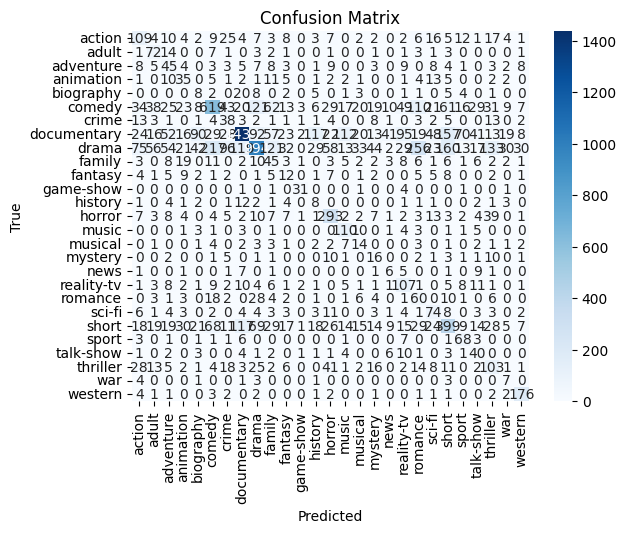

In [10]:
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Model Test using Test data**

In [11]:
test_data['predicted_genre'] = model.predict(X_test)

# Display predictions
print(test_data[['title', 'predicted_genre']].head())

                         title predicted_genre
0         Edgar's Lunch (1998)          comedy
1     La guerra de papá (1977)           drama
2  Off the Beaten Track (2010)     documentary
3       Meu Amigo Hindu (2015)           drama
4            Er nu zhai (1955)           drama


**Croos-Validation**

**Save the Model**

In [13]:
import pickle

with open('movie_genre_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)


**Check the Model with real data**

In [14]:
with open('movie_genre_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_tfidf = pickle.load(vectorizer_file)

new_plot = "A young wizard battles dark forces and learns the power of friendship."
new_plot_cleaned = clean_text(new_plot)
new_plot_vectorized = loaded_tfidf.transform([new_plot_cleaned])
predicted_genre = loaded_model.predict(new_plot_vectorized)

print("Predicted Genre:", predicted_genre[0])


Predicted Genre: fantasy
